In [5]:
"""
(C) Yu-Hao Chen (2023)

This is the accompanying code for the paper
'Making the zeroth-order process fidelity independent of state preparation and measurement errors'
Yu-Hao Chen, Renata Wong, Hi-Sheng Goan
"""



import numpy as np
import matplotlib.pyplot as plt
import itertools
from qutip import sigmax, sigmay, sigmaz, qeye, Qobj, tensor, ket2dm
from qutip.measurement import measure_observable

from qutip import (Qobj, basis, gate_expand_1toN, qeye,
                   sigmax, sigmay, sigmaz, snot, tensor, rx, ry, rz, cnot, cphase)

from scipy import linalg

import copy
import itertools
from typing import List, Union

from qiskit import IBMQ, Aer, execute, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.utils import QuantumInstance 

from qiskit.circuit import Parameter
from qiskit.compiler import transpile


# Import general libraries (needed for functions)
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import display

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
import qiskit.circuit.library as circuits
import qiskit.quantum_info as qi

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from qiskit.opflow import I, X, Y, Z
from qiskit_aer import QasmSimulator

backend = AerSimulator.from_backend(FakeParis())



# Packages related to state preparation and measurement (SPAM) errors
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import Kraus, SuperOp, DensityMatrix, state_fidelity, process_fidelity, average_gate_fidelity
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


from typing import List, Optional, Union
from warnings import warn
from numpy.random import RandomState


from qiskit.quantum_info import Clifford
from qiskit.quantum_info import random_clifford
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.extensions import RXGate, XGate, CXGate

from qiskit.circuit import QuantumCircuit, Instruction
from qiskit.quantum_info import Clifford, CNOTDihedral
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.transpiler.passes import RemoveBarriers





def get_parity(n):
    parity = 0
    while n:
        parity = ~parity
        n = n & (n - 1)
    return parity


def expectation_value_from_counts(counts, nqubits, nshots):
    exp_val = 0
    for x in map(''.join, itertools.product('01', repeat=nqubits)):
        if x in counts:   # making sure that x is in the output as the counts dictionary contains no values with 0 occurrence
            if get_parity(int(x,2)) == -1:
                exp_val = exp_val - counts[x]
            if get_parity(int(x,2)) == 0:
                exp_val = exp_val + counts[x]
    return exp_val/nshots


#from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error


depolarizing_model = NoiseModel()

# add depolarizing noise to 3 qubits u gates
error_d = depolarizing_error(0.12, 1) # 0.018
# 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12]
error_d_cx = depolarizing_error(0.12, 2)
#depolarizing_model.add_all_qubit_quantum_error(error_d, "reset")
#depolarizing_model.add_all_qubit_quantum_error(error_d, "u")
#depolarizing_model.add_all_qubit_quantum_error(error_d, "measure")
depolarizing_model.add_all_qubit_quantum_error(error_d_cx, "cz")
noise_simulator = AerSimulator(noise_model=depolarizing_model)
noise_simulator

Initial_noise = SuperOp(error_d).to_instruction()
Initial_noise.label = "noise"

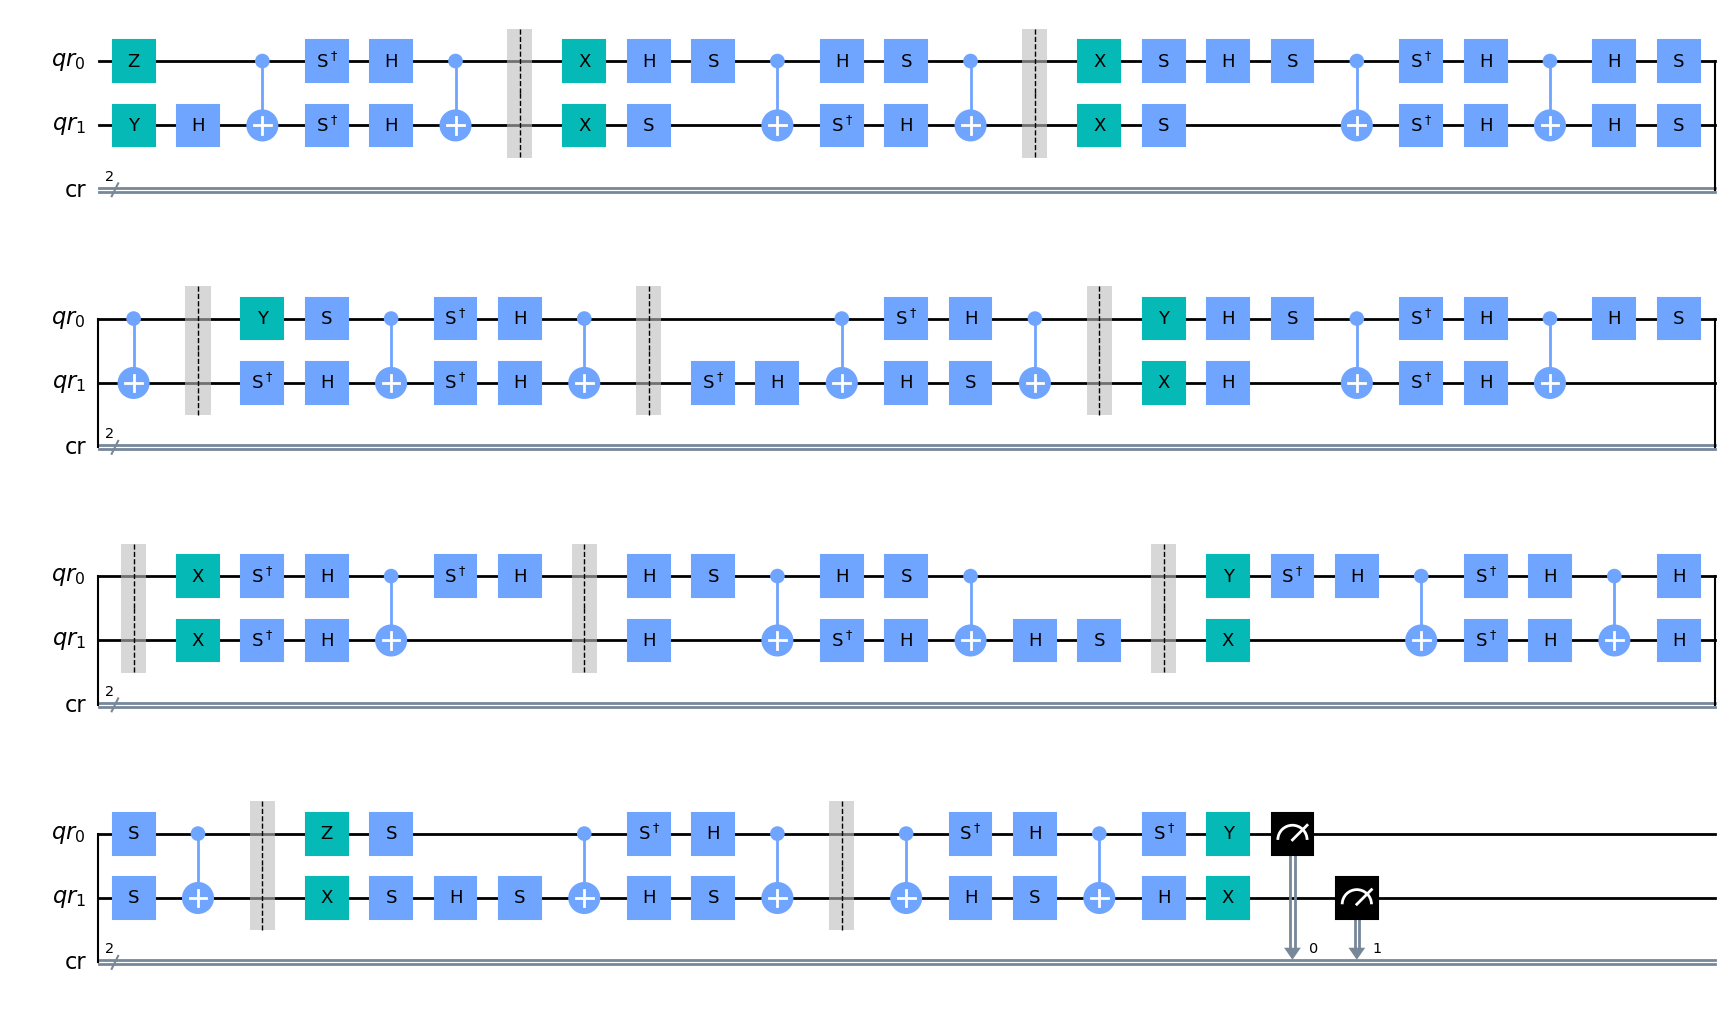

In [7]:
# Generating two-qubit RB circuit


import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
from qiskit.ignis.verification import randomized_benchmarking_seq

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#number of qubits
nQ=2
rb_opts = {}

#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 150, 175, 200, 250] #[1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
length_vector = [1, 10, 20, 50, 75, 100, 135, 180] #[1, 10, 20, 30, 35, 40, 45, 50]

#Number of seeds (random sequences)
rb_opts['nseeds'] = 5
nseeds = 5

#Default pattern
rb_opts['rb_pattern'] = [ [0, 1] ]
rb_pattern = [ [0, 1] ]
rb_opts["interleaved_gates"] = [["cz 0 1"]]
#interleaved_gates = [["cz 0 1"]]
#cx_qc = QuantumCircuit(2)

#cx_qc.cx(0, 1)
#cx_qc.cx(1, 2)

#interleaved_elem = [cx_qc]

#rb_circs, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(**rb_opts)
return_data = rb.randomized_benchmarking_seq(nseeds=nseeds, length_vector=length_vector, rb_pattern=rb_pattern
                                        )

original_circuits, xdata = return_data
original_circuits[0][1].draw("mpl")

In [8]:
# Generating circuits with SPAM errors for RB where the initial states are the SIC-states

INPUT_STATE = [[0, 0, 0], [2 * np.arccos(np.sqrt(1/3)), 0, 0], [2 * np.arccos(np.sqrt(1/3)), 2 * np.pi/3, 0],
                     [2 * np.arccos(np.sqrt(1/3)), 4 * np.pi/3, 0]]
nqubits = 2
Circuit_list = [1]


def generate_circuits_SAPM(nqubits, Circuit_list):
    
    params = ParameterVector('p', 2 * 3 * nqubits)
    half_len_params = int(len(params)/2)

    qr = QuantumRegister(nqubits, 'q')
    cr = ClassicalRegister(nqubits, 'c')
    
    circuits = []
    state_prep = []
    measur_list = []
    rb_circ_lists = []
    inputs = [''.join(i) for i in itertools.product('0123', repeat=nqubits)]
    paulis = [''.join(i) for i in itertools.product('IXYZ', repeat=nqubits)]
    
    
    # generating circuits for each combination of input state and Pauli operator
    
    for digit_string in inputs:

        qc = QuantumCircuit(qr, cr)

        # append input states
        for digit, qubit in zip(digit_string, range(qc.num_qubits)):
            qc.u(INPUT_STATE[int(digit)][0], INPUT_STATE[int(digit)][1], INPUT_STATE[int(digit)][2], qubit)
        qc.barrier()
        
        # for state preparation error
        #for n in range(nqubits):
        #    degrees = np.random.normal(0, np.sqrt(5), size=(1, 3))
        #    qc.u(2*degrees[0][0]*(np.pi)/180, degrees[0][1]*(np.pi)/180, degrees[0][2]*(np.pi)/180, n)

        qc.barrier()
        state_prep.append(qc)
        
    for pauli in paulis:
        qc_m = QuantumCircuit(qr, cr)
        qc_m.barrier()
        
        for single_pauli, qubit in zip(pauli, range(qc_m.num_qubits)):
            if single_pauli == 'I':
                qc_m.reset(qubit)
            if single_pauli == 'X':
                qc_m.h(qubit)
            if single_pauli == 'Y':
                qc_m.h(qubit)
                qc_m.p(-np.pi/2, qubit)
            if single_pauli == 'Z':
                pass
        
        qc_m.measure(qr, cr)
        measur_list.append(qc_m)
        
        
    count = 1
    for j in original_circuits:
        rb_circuit_list = []
        
        for i in state_prep:
            for k in j:
                cir = i.compose(k)
                cir = cir.remove_final_measurements(inplace=False)
                rb_circuit_list.append(cir)
        
        count += 1
        circuits.append(rb_circuit_list)
        
    count = 1
    for i in circuits:
        rb_circ_list = []
        
        for m in measur_list:
            for k in i:
                cir = k.compose(m)
                rb_circ_list.append(cir)
                
        count += 1
        rb_circ_lists.append(rb_circ_list)
                

            
     
    return circuits, rb_circ_lists


circuits_rb_SPAM = generate_circuits_SAPM(nqubits, Circuit_list)[1]

len(circuits_rb_SPAM[0])

2048

In [9]:
# Generating circuits without SPAM errors for RB where the initial states are the SIC-states

INPUT_STATE = [[0, 0, 0], [2 * np.arccos(np.sqrt(1/3)), 0, 0], [2 * np.arccos(np.sqrt(1/3)), 2 * np.pi/3, 0],
                     [2 * np.arccos(np.sqrt(1/3)), 4 * np.pi/3, 0]]
nqubits = 2
Circuit_list = [1]


def generate_circuits(nqubits, Circuit_list):
    
    params = ParameterVector('p', 2 * 3 * nqubits)
    half_len_params = int(len(params)/2)

    qr = QuantumRegister(nqubits, 'q')
    cr = ClassicalRegister(nqubits, 'c')
    
    circuits = []
    state_prep = []
    measur_list = []
    rb_circ_lists = []
    inputs = [''.join(i) for i in itertools.product('0123', repeat=nqubits)]
    paulis = [''.join(i) for i in itertools.product('IXYZ', repeat=nqubits)]

    
    # generating circuits for each combination of input state and Pauli operator
    
    for digit_string in inputs:

        qc = QuantumCircuit(qr, cr)

        # append input states
        for digit, qubit in zip(digit_string, range(qc.num_qubits)):
            qc.u(INPUT_STATE[int(digit)][0], INPUT_STATE[int(digit)][1], INPUT_STATE[int(digit)][2], qubit)
        
        qc.barrier()
        
        state_prep.append(qc)
        
    for pauli in paulis:
        qc_m = QuantumCircuit(qr, cr)
        qc_m.barrier()
        
        for single_pauli, qubit in zip(pauli, range(qc_m.num_qubits)):
            if single_pauli == 'I':
                qc_m.reset(qubit)
            if single_pauli == 'X':
                qc_m.h(qubit)
            if single_pauli == 'Y':
                qc_m.h(qubit)
                qc_m.p(-np.pi/2, qubit)
            if single_pauli == 'Z':
                pass
        
        qc_m.measure(qr, cr)
        measur_list.append(qc_m)
        
    
    count = 1
    for j in original_circuits:
        rb_circuit_list = []
        
        for i in state_prep:
            for k in j:
                cir = i.compose(k)
                cir = cir.remove_final_measurements(inplace=False)
                rb_circuit_list.append(cir)
        
        count += 1
        circuits.append(rb_circuit_list)
        
    count = 1
    for i in circuits:
        rb_circ_list = []
        
        for m in measur_list:
            for k in i:
                cir = k.compose(m)
                rb_circ_list.append(cir)
        
        count += 1
        rb_circ_lists.append(rb_circ_list)
                

            
     
    return circuits, rb_circ_lists


circuits_rb = generate_circuits(nqubits, Circuit_list)[1]

len(circuits_rb[0])

2048

In [10]:
# Creating noise for circuits

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile


noise_model = NoiseModel()

readout_1 = 0.03
readout_0 = 0.05
readout_error = ReadoutError([[1-readout_1, readout_1], [readout_0, 1-readout_0]])

dep_2 = depolarizing_error(0.01, 2) # 0.01
dep = depolarizing_error(0.003, 1) # 0.003

noise_model.add_all_qubit_quantum_error(dep_2, "cx")
#noise_model.add_all_qubit_quantum_error(dep_2, "cz")
noise_model.add_all_qubit_quantum_error(dep, "x")
noise_model.add_all_qubit_quantum_error(dep, "y")
noise_model.add_all_qubit_quantum_error(dep, "h")
noise_model.add_readout_error(readout_error, [0])
noise_model.add_readout_error(readout_error, [1])

In [11]:
# Calculating the fidelity of sequence 1

from qiskit_aer import QasmSimulator


def expectation_values(nqubits, noisy=False):
    
    params = np.linspace(0, 0, 6 * nqubits)
    
    if noisy == True:
        #backend = noise_simulator  #FakeManilaV2()
        noise_simulator = AerSimulator(noise_model=noise_model)
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits_SAPM(nqubits, Circuit_list)[1][0]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            backend = transpile(circuit, noise_simulator)
            #results = execute(circuit, backend, shots=nshots).result()
            results = noise_simulator.run(backend).result()
            counts = results.get_counts(circuit)
            counts_dict = counts
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)
        
    if noisy == False:
        backend = QasmSimulator(method='statevector') #Aer.get_backend('qasm_simulator')
    
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits(nqubits, Circuit_list)[1][0]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            results = execute(circuit, backend, shots=nshots).result()
            counts = results.get_counts(circuit)
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)

    return expvals


expct = expectation_values(nqubits, noisy=True)
exp_f = expectation_values(nqubits, noisy=False)


rb_zero_fidelity = 0.0

data_lists_SPAM = []
data_lists = []

for i in range(8):
    data_list_SPAM = []
    data_list = []
    
    for j in range(16):  
        for k in range(16): 
            data_list_SPAM.append(expct[128*k+(j*8)+i]) 
            data_list.append(exp_f[128*k+(j*8)+i]) 
    
    data_lists_SPAM.append(data_list_SPAM)
    data_lists.append(data_list)
    
C_length = []

for i in range(len(data_lists)):
    rb_zero_fidelitys = []
    for j in range(len(data_lists_SPAM[i])):
        rb_zero_fidelity = (data_lists_SPAM[i][j] * data_lists[i][j])
        rb_zero_fidelitys.append(rb_zero_fidelity)
    C_length.append(rb_zero_fidelitys)

    
Zero_Fid_rb = C_length[::-1]
fids = []

for i in range(len(C_length)):
    fids.append(sum(C_length[i])/64)
    
sec_0 = fids
sec_0

[0.8264034390449524,
 0.6809486746788025,
 0.593811571598053,
 0.41159605979919434,
 0.3363076448440552,
 0.28506898880004883,
 0.24194175004959106,
 0.23246079683303833]

In [ ]:
# Calculating the fidelity of sequence 2

from qiskit_aer import QasmSimulator


def expectation_values(nqubits, noisy=False):
    params = np.linspace(0, 0, 6 * nqubits)
    if noisy == True:
        #backend = noise_simulator  #FakeManilaV2()
        noise_simulator = AerSimulator(noise_model=noise_model)
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits_SAPM(nqubits, Circuit_list)[1][1]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            backend = transpile(circuit, noise_simulator)
            #results = execute(circuit, backend, shots=nshots).result()
            results = noise_simulator.run(backend).result()
            counts = results.get_counts(circuit)
            counts_dict = counts
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)
        
    if noisy == False:
        backend = QasmSimulator(method='statevector') #Aer.get_backend('qasm_simulator')
    
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits(nqubits, Circuit_list)[1][1]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            results = execute(circuit, backend, shots=nshots).result()
            counts = results.get_counts(circuit)
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)

    return expvals


expct = expectation_values(nqubits, noisy=True)
exp_f = expectation_values(nqubits, noisy=False)

rb_zero_fidelity = 0.0

data_lists_SPAM = []
data_lists = []

for i in range(8):
    data_list_SPAM = []
    data_list = []
    for j in range(16): 
        for k in range(16): 
            data_list_SPAM.append(expct[128*k+(j*8)+i]) 
            data_list.append(exp_f[128*k+(j*8)+i]) 
    
    data_lists_SPAM.append(data_list_SPAM)
    data_lists.append(data_list)
    
    
C_length = []

for i in range(len(data_lists)):
    rb_zero_fidelitys = []
    for j in range(len(data_lists_SPAM[i])):
        rb_zero_fidelity = (data_lists_SPAM[i][j] * data_lists[i][j])
        rb_zero_fidelitys.append(rb_zero_fidelity)
    C_length.append(rb_zero_fidelitys)

Zero_Fid_rb = C_length[::-1]
fids = []

for i in range(len(C_length)):
    fids.append(sum(C_length[i])/64)
    
sec_1 = fids
sec_1

In [ ]:
# Calculating the fidelity of sequence 3

from qiskit_aer import QasmSimulator

def expectation_values(nqubits, noisy=False):
    params = np.linspace(0, 0, 6 * nqubits)
    if noisy == True:
        #backend = noise_simulator  #FakeManilaV2()
        noise_simulator = AerSimulator(noise_model=noise_model)
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits_SAPM(nqubits, Circuit_list)[1][2]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            backend = transpile(circuit, noise_simulator)
            #results = execute(circuit, backend, shots=nshots).result()
            results = noise_simulator.run(backend).result()
            counts = results.get_counts(circuit)
            counts_dict = counts
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)
        
    if noisy == False:
        backend = QasmSimulator(method='statevector') #Aer.get_backend('qasm_simulator')
    
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits(nqubits, Circuit_list)[1][2]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            results = execute(circuit, backend, shots=nshots).result()
            counts = results.get_counts(circuit)
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)

    return expvals


expct = expectation_values(nqubits, noisy=True)
exp_f = expectation_values(nqubits, noisy=False)

rb_zero_fidelity = 0.0

data_lists_SPAM = []
data_lists = []

for i in range(8):
    data_list_SPAM = []
    data_list = []
    for j in range(16): 
        for k in range(16):
            data_list_SPAM.append(expct[128*k+(j*8)+i]) 
            data_list.append(exp_f[128*k+(j*8)+i]) 
    
    data_lists_SPAM.append(data_list_SPAM)
    data_lists.append(data_list)
    
    
C_length = []
for i in range(len(data_lists)):
    rb_zero_fidelitys = []
    for j in range(len(data_lists_SPAM[i])):
        rb_zero_fidelity = (data_lists_SPAM[i][j] * data_lists[i][j])
        rb_zero_fidelitys.append(rb_zero_fidelity)
    C_length.append(rb_zero_fidelitys)

Zero_Fid_rb = C_length[::-1]
fids = []

for i in range(len(C_length)):
    fids.append(sum(C_length[i])/64)
    
sec_2 = fids
sec_2

In [ ]:
# Calculating the fidelity of sequence 4

from qiskit_aer import QasmSimulator

def expectation_values(nqubits, noisy=False):
    params = np.linspace(0, 0, 6 * nqubits)
    if noisy == True:
        #backend = noise_simulator  #FakeManilaV2()
        noise_simulator = AerSimulator(noise_model=noise_model)
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits_SAPM(nqubits, Circuit_list)[1][3]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            backend = transpile(circuit, noise_simulator)
            #results = execute(circuit, backend, shots=nshots).result()
            results = noise_simulator.run(backend).result()
            counts = results.get_counts(circuit)
            counts_dict = counts
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)
        
    if noisy == False:
        backend = QasmSimulator(method='statevector') #Aer.get_backend('qasm_simulator')
    
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits(nqubits, Circuit_list)[1][3]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            results = execute(circuit, backend, shots=nshots).result()
            counts = results.get_counts(circuit)
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)

    return expvals


expct = expectation_values(nqubits, noisy=True)
exp_f = expectation_values(nqubits, noisy=False)

rb_zero_fidelity = 0.0

data_lists_SPAM = []
data_lists = []

for i in range(8):
    data_list_SPAM = []
    data_list = []
    for j in range(16): 
        for k in range(16): 
            data_list_SPAM.append(expct[128*k+(j*8)+i]) 
            data_list.append(exp_f[128*k+(j*8)+i]) 
    
    data_lists_SPAM.append(data_list_SPAM)
    data_lists.append(data_list)
    
C_length = []
for i in range(len(data_lists)):
    rb_zero_fidelitys = []
    for j in range(len(data_lists_SPAM[i])):
        rb_zero_fidelity = (data_lists_SPAM[i][j] * data_lists[i][j])
        rb_zero_fidelitys.append(rb_zero_fidelity)
    C_length.append(rb_zero_fidelitys)

Zero_Fid_rb = C_length[::-1]
fids = []
for i in range(len(C_length)):
    fids.append(sum(C_length[i])/64)
    
sec_3 = fids
sec_3

In [ ]:
# Calculating the fidelity of sequence 5

from qiskit_aer import QasmSimulator

def expectation_values(nqubits, noisy=False):
    params = np.linspace(0, 0, 6 * nqubits)
    if noisy == True:
        #backend = noise_simulator  #FakeManilaV2()
        noise_simulator = AerSimulator(noise_model=noise_model)
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits_SAPM(nqubits, Circuit_list)[1][4]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            backend = transpile(circuit, noise_simulator)
            #results = execute(circuit, backend, shots=nshots).result()
            results = noise_simulator.run(backend).result()
            counts = results.get_counts(circuit)
            counts_dict = counts
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)
        
    if noisy == False:
        backend = QasmSimulator(method='statevector') #Aer.get_backend('qasm_simulator')
    
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits(nqubits, Circuit_list)[1][4]#generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            results = execute(circuit, backend, shots=nshots).result()
            counts = results.get_counts(circuit)
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)

    return expvals


expct = expectation_values(nqubits, noisy=True)
exp_f = expectation_values(nqubits, noisy=False)

rb_zero_fidelity = 0.0

data_lists_SPAM = []
data_lists = []

for i in range(8):
    data_list_SPAM = []
    data_list = []
    for j in range(16):
        for k in range(16): 
            data_list_SPAM.append(expct[128*k+(j*8)+i]) 
            data_list.append(exp_f[128*k+(j*8)+i]) 
    
    data_lists_SPAM.append(data_list_SPAM)
    data_lists.append(data_list)
    
C_length = []
for i in range(len(data_lists)):
    rb_zero_fidelitys = []
    for j in range(len(data_lists_SPAM[i])):
        rb_zero_fidelity = (data_lists_SPAM[i][j] * data_lists[i][j])
        rb_zero_fidelitys.append(rb_zero_fidelity)
    C_length.append(rb_zero_fidelitys)

Zero_Fid_rb = C_length[::-1]
fids = []
for i in range(len(C_length)):
    fids.append(sum(C_length[i])/64)
    
sec_4 = fids
sec_4

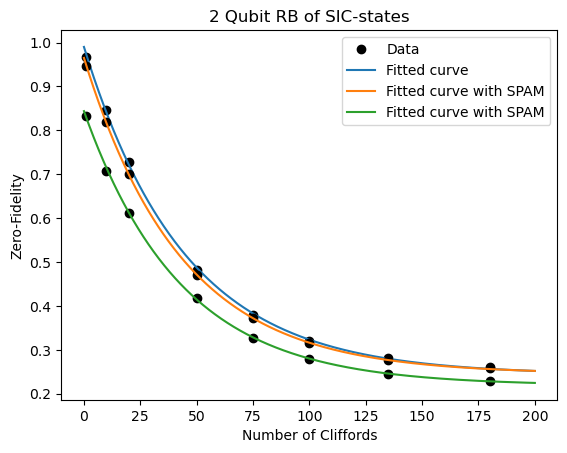

A_0:0.7466169164517674, alpha:0.9778802128159069, B_0:0.24331405023374233
Error per Clifford (EPC):0.01658984038806985
A_0:0.7198905451721402, alpha:0.9771327335213607, B_0:0.24491520206799952
Error per Clifford (EPC):0.01715044985897951
A_0:0.6251196482680299, alpha:0.9770678037283795, B_0:0.2185448127076124
Error per Clifford (EPC):0.017199147203715348


In [12]:
# Below are the fidelities of RB circuit without SPAM. Based on these fidelities we can generate Fig. 7 in the paper.


two_qubit_RB0 = [0.9762818813323975,
 0.8719520568847656,
 0.748766303062439,
 0.4868919253349304,
 0.3688323497772217,
 0.31280791759490967,
 0.27030134201049805,
 0.2606580853462219]
two_qubit_RB1 = [0.9715672731399536,
 0.8270230889320374,
 0.7504792809486389,
 0.4858723282814026,
 0.3827531337738037,
 0.31919246912002563,
 0.2831020951271057,
 0.2586802840232849]
two_qubit_RB2 = [0.9637641310691833,
 0.8251849412918091,
 0.7051650881767273,
 0.4876633286476135,
 0.38089001178741455,
 0.32631343603134155,
 0.28341513872146606,
 0.25597524642944336]
two_qubit_RB3 = [0.9486096501350403,
 0.8381244540214539,
 0.6908680200576782,
 0.4617525339126587,
 0.37263399362564087,
 0.3152710795402527,
 0.2751207947731018,
 0.25901859998703003]
two_qubit_RB4 = [0.9692736864089966,
 0.8722133040428162,
 0.742385745048523,
 0.4904414415359497,
 0.39207351207733154,
 0.3287864923477173,
 0.2926294803619385,
 0.2667224407196045]


ave_two_qubit_RB = []
for i in range(len(two_qubit_RB0)):
    ave_two_qubit_RB.append((two_qubit_RB0[i]+two_qubit_RB1[i]+two_qubit_RB2[i]+two_qubit_RB3[i]+two_qubit_RB4[i])/(5))




# These are fidelities of RB circuit with SPAM where measurement error is the weaker readout error

two_qubit_RB_weak0 = [0.9627322554588318,
 0.8145718574523926,
 0.6898131966590881,
 0.45930469036102295,
 0.3663145899772644,
 0.3100208640098572,
 0.27395641803741455,
 0.2578820586204529]
two_qubit_RB_weak1 = [0.9308457970619202,
 0.8111584782600403,
 0.7046991586685181,
 0.47773200273513794,
 0.371887743473053,
 0.3162720203399658,
 0.28065913915634155,
 0.26027941703796387]
two_qubit_RB_weak2 = [0.950425922870636,
 0.8313088417053223,
 0.7094321846961975,
 0.46738582849502563,
 0.3683256506919861,
 0.31740498542785645,
 0.2753458619117737,
 0.2543870806694031]
two_qubit_RB_weak3 = [0.9458042979240417,
 0.8319199085235596,
 0.7080967426300049,
 0.47413307428359985,
 0.3843870162963867,
 0.31141364574432373,
 0.278145432472229,
 0.25375115871429443]
two_qubit_RB_weak4 = [0.9413802027702332,
 0.8037634491920471,
 0.6847755312919617,
 0.468108594417572,
 0.3732496500015259,
 0.31845253705978394,
 0.27274417877197266,
 0.2615232467651367]



ave_two_qubit_RB_weak = []
for i in range(len(two_qubit_RB_weak4)):
    ave_two_qubit_RB_weak.append((two_qubit_RB_weak0[i]+two_qubit_RB_weak1[i]+two_qubit_RB_weak2[i]+two_qubit_RB_weak3[i]+two_qubit_RB_weak4[i])/(5))




# These are fidelities of RB circuit with SPAM where measurement error is the stronger readout error

two_qubit_RB_strong0 = [0.8111873269081116,
 0.7056352496147156,
 0.6008601784706116,
 0.41154778003692627,
 0.30957239866256714,
 0.26584774255752563,
 0.2458479404449463,
 0.22993344068527222]
two_qubit_RB_strong1 = [0.8140718936920166,
 0.6950252652168274,
 0.596483051776886,
 0.4120141863822937,
 0.3379884362220764,
 0.2871372699737549,
 0.2445836067199707,
 0.22533023357391357]
two_qubit_RB_strong2 = [0.8423026204109192,
 0.7200984954833984,
 0.6364669799804688,
 0.4313325881958008,
 0.34150516986846924,
 0.2913095951080322,
 0.24905717372894287,
 0.22868430614471436]
two_qubit_RB_strong3 = [0.8444990515708923,
 0.7124935388565063,
 0.6310804486274719,
 0.4318044185638428,
 0.32639747858047485,
 0.2771977186203003,
 0.24624884128570557,
 0.23002725839614868]
two_qubit_RB_strong4 = [0.854168176651001,
 0.7062846422195435,
 0.5945810079574585,
 0.4055517315864563,
 0.3209746479988098,
 0.27680695056915283,
 0.24111753702163696,
 0.2264959216117859]

perfect_2 = [1.0051958560943604,
 0.9970776438713074,
 1.002712368965149,
 1.0056989789009094,
 1.0019776821136475,
 1.00563383102417,
 1.008792519569397,
 1.004904329776764]


ave_two_qubit_RB_strong = []
for i in range(len(two_qubit_RB_weak4)):
    ave_two_qubit_RB_strong.append((two_qubit_RB_strong0[i]+two_qubit_RB_strong1[i]+two_qubit_RB_strong2[i]+two_qubit_RB_strong3[i]+two_qubit_RB_strong4[i])/(5))
    

    
# This code generates the figure for RB    

num_cliffords = [1, 10, 20, 50, 75, 100, 135, 180]

from pylab import *
from scipy.optimize import curve_fit
def func(x, a, c, d):
    return a*np.exp(-c*x)+d
x = num_cliffords
y = np.array(ave_two_qubit_RB)
y_w = np.array(ave_two_qubit_RB_weak)
y_s = np.array(ave_two_qubit_RB_strong)

popt, pcov = curve_fit(func, x, y, p0=(1, 1e-2, 1))
popt_w, pcov_w = curve_fit(func, x, y_w, p0=(1, 1e-2, 1))
popt_s, pcov_s = curve_fit(func, x, y_s, p0=(1, 1e-2, 1))

fit_x = np.linspace(0, 200, 1000)
fit_y = func(fit_x, *popt)

fit_y_w = func(fit_x, *popt_w)
fit_y_s = func(fit_x, *popt_s)




plot(x, y, 'ko', label="Data")
plot(fit_x, fit_y, label="Fitted curve")

plot(x, y_w, 'ko')
plot(fit_x, fit_y_w, label="Fitted curve with SPAM")

plot(x, y_s, 'ko')
plot(fit_x, fit_y_s, label="Fitted curve with SPAM")
"""
plt.text(98, 0.75, r'$\alpha$= 0.917 EPC = 6.220e-02', size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",  facecolor="white",))
"""
plt.xlabel("Number of Cliffords")
plt.ylabel(r"Zero-Fidelity")
plt.title("2 Qubit RB of SIC-states")
plt.legend()
plt.show()


n = 2
coe = (2**n-1)/2**n
print("A_0:{}, alpha:{}, B_0:{}".format(popt[0], np.exp(-popt[1]), popt[2]))
print("Error per Clifford (EPC):{}".format(((coe)*(1-np.exp(-popt[1])))))

print("A_0:{}, alpha:{}, B_0:{}".format(popt_w[0], np.exp(-popt_w[1]), popt_w[2]))
print("Error per Clifford (EPC):{}".format(((coe)*(1-np.exp(-popt_w[1])))))

print("A_0:{}, alpha:{}, B_0:{}".format(popt_s[0], np.exp(-popt_s[1]), popt_s[2]))
print("Error per Clifford (EPC):{}".format(((coe)*(1-np.exp(-popt_s[1])))))
#print("The fidelity of CX gate:{}".format(1-(0.07256864105893496-0.04043036074972145)/0.9537938734288898)) #0.9711183955199194